In [7]:
%run SPDEs.ipynb
%run SPDEs2D.ipynb
%run Rule.ipynb
%run Noise.ipynb
%run Algorithm_1.ipynb
%run Model.ipynb
%run Experiment.ipynb

In [26]:
dt = 0.001 #space-time increments 
k = 100 # Number of realizations
X, T = 1, 1 # space time domain [0,T]x[0,X]^2
N = 64 # number of space points in the mesh
visc = 1 # viscosity in fron of Laplacian

T_, X_ = np.linspace(0,T,int(np.ceil(T/dt))+1), np.linspace(0,X,N+1)

# initial condition (constant for all realizations)
x, y = np.meshgrid(X_[:-1], X_[0:-1])
u0 = np.sin(2*np.pi*(x + y)) + np.cos(2*np.pi*(x + y))
u0 = np.array([u0]*k)

mu = lambda x: 3*x-x**3 # drift
sigma = lambda x: x # multiplicative diffusive term

In [27]:
W = coloured_noise_2d(T, dt, X, N, k) # Create realizations of space time white noise

\begin{align}
(\partial_t - \Delta) u &= 3u - u^3 + u\cdot\xi\,\quad\text{for $(t,x,y) \in [0,1]\times \mathbb{T}^2$,}\\
u(t,0) &= u(t,1)\quad\text{(Periodic BC)}\\
u(0,x,y) &= \cos(2\pi(x+y)) + \sin(2\pi(x+y))
\end{align}

In [28]:
# solutions to the multiplicative equation 
Soln = general_2d_solver(visc, u0, W, mu = mu, sigma = sigma, dt=dt)

100%|██████████| 999/999 [03:48<00:00,  4.37it/s]


\begin{align}
(\partial_t - \Delta) I[\xi] &= \xi\,\quad\text{for $(t,x) \in [0,1]\times [0,1]$,}\\
I[\xi](t,0) &= I[\xi](t,1)\\
I[\xi](0,x) &= 0
\end{align}

In [29]:
# solutions to the linearized equation

I_xi = general_2d_solver(visc, u0, W, dt=dt)

# Will be used as an input to the model in order to speed up the model computation. All I_xi are solved in paralel

100%|██████████| 999/999 [00:26<00:00, 37.13it/s]


In [30]:
R = Rule(kernel_deg = 2, noise_deg = -1.5, free_num = 3) # create rule with additive width 3

R.add_component(1, {'xi':1}) # add multiplicative width = 1

Integral = trees_integrator_2D(visc, X, N, T, dt).integrate # initialize integration map I

M = Model(integration = Integral, rule = R, height = 3, deg = 5) # initialize model

p1 = (50,32,32)
p2 = (500,32,32)
p3 = (-1,32,32)
p4 = (-1,16,16)
points = {p1, p2, p3, p4}

# create model
Features_for_points = M.create_model_points(W, diff = True, lollipops = I_xi, dt = dt, points = points)

100%|██████████| 100/100 [12:18<00:00,  7.39s/it]


In [16]:
# Create subsets of symbols for models of lower heights

W_toy = np.zeros(shape = (1, 2, 2)) # small toy noise
I_toy = SPDE(BC = 'P', T = np.array([0,1]), X = np.array([0,1])).Integrate_Parabolic_trees

M_toy = {i : Model(I_toy, R, i, 5) for i in range(1,4)} # initialize toy models of heights 1,2,3,4

for a in M_toy:
    
    M_toy[a].create_model_list(W_toy, lollipops = W_toy, diff = True, dt = 1)
    
trees = {a: list(M_toy[a].models[0].keys()) for a in M_toy} # extract feature set for every height

trees_add = [a for a in trees[3] if 'xi(' not in a] # feature set for model without forcing

100%|██████████| 1/1 [00:00<00:00, 213.54it/s]


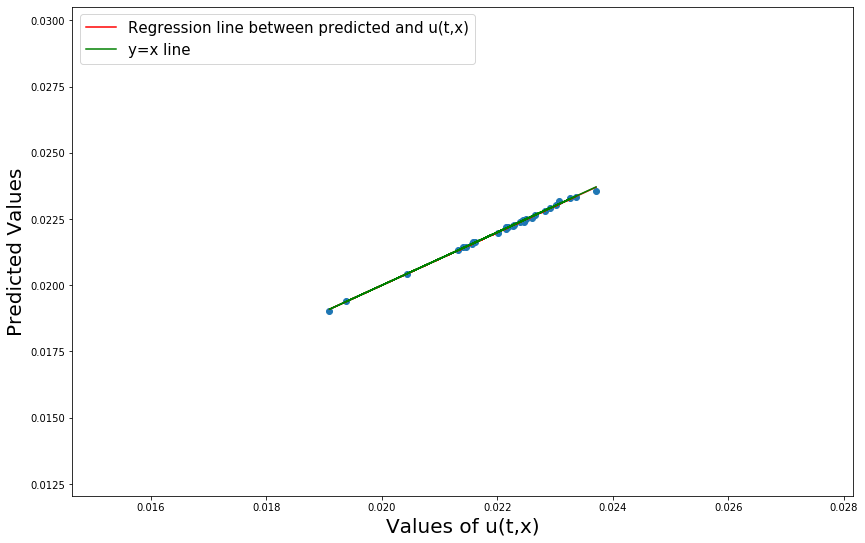

Error: 0.0022560089849544256. Error std: 0.002220853561169754. Tangent: 0.9976103541133361. R^2: 0.9976123963064595.
Prediction at (t,x,y) = (0.05,0.5,0.5)


In [37]:
#  Multiplicative equation experiment

p = p1
E1 = Experiment(None, None)
E1.F = Features_for_points[p]
E1.L = Soln[:,p[0],p[1],p[2]]
E1.one_experiment(split = True)
E1.show_regression_experiment(metric = err2)
print('Prediction at (t,x,y) = ({},{},{})'.format(T_[p[0]], X_[p[1]], X_[p[1]]))

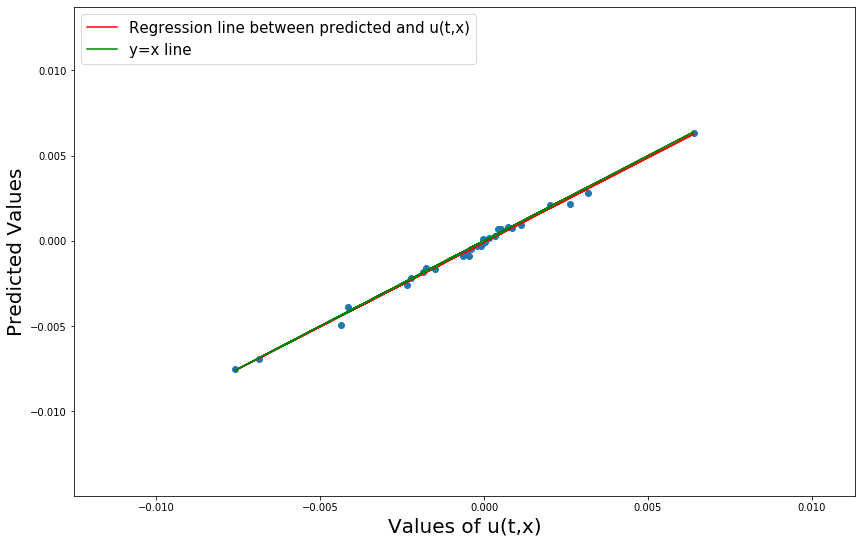

Error: 0.07853658582992724. Error std: 0.07837121313874101. Tangent: 0.9914632788127075. R^2: 0.993565283745033.
Prediction at (t,x,y) = (0.5,0.5,0.5)


In [38]:
#  Multiplicative equation experiment

p = p2
E2 = Experiment(None, None)
E2.F = Features_for_points[p]
E2.L = Soln[:,p[0],p[1],p[2]]
E2.one_experiment(split = True)
E2.show_regression_experiment(metric = err2)
print('Prediction at (t,x,y) = ({},{},{})'.format(T_[p[0]], X_[p[1]], X_[p[1]]))

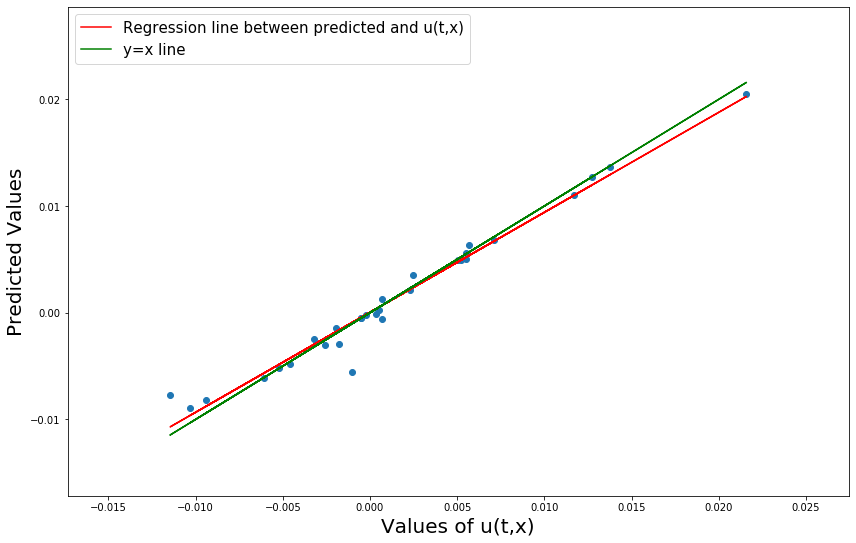

Error: 0.17095586413753228. Error std: 0.17023558932303. Tangent: 0.9371364298729519. R^2: 0.9696591753884942.
Prediction at (t,x,y) = (1.0,0.5,0.5)


In [39]:
#  Multiplicative equation experiment

p = p3
E3 = Experiment(None, None)
E3.F = Features_for_points[p]
E3.L = Soln[:,p[0],p[1],p[2]]
E3.one_experiment(split = True)
E3.show_regression_experiment(metric = err2)
print('Prediction at (t,x,y) = ({},{},{})'.format(T_[p[0]], X_[p[1]], X_[p[1]]))

In [40]:
#  Repeated experiments

repeat_num = 1000
E = E1
p = p1
er1, std1, t1, r1 = E.many_regression_experiments(repeat_num, columns = trees[1])
er2, std2, t2, r2 = E.many_regression_experiments(repeat_num, columns = trees[2])
er3, std3, t3, r3 = E.many_regression_experiments(repeat_num, columns = trees[3])
er1, std1, t1, r1 = round(100*er1, 2), round(100*std1, 2), round(t1, 3), round(r1, 3)
er2, std2, t2, r2 = round(100*er2, 2), round(100*std2, 2), round(t2, 3), round(r2, 3)
er3, std3, t3, r3 = round(100*er3, 2), round(100*std3, 2), round(t3, 3), round(r3, 3)

100%|██████████| 1000/1000 [00:05<00:00, 198.37it/s]


In [41]:
print('Repeating Experiment {} times. Prediction at (t,x,y) = ({},{},{})'.format(repeat_num, T_[p[0]], X_[p[1]], X_[p[1]]))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(1, er1, std1, t1, r1))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(2, er2, std2, t2, r2))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(3, er3, std3, t3, r3))

Repeating Experiment 1000 times. Prediction at (t,x,y) = (0.05,0.5,0.5)
Height = 1, Avg Error: 5.98%. Avg Error Std 5.89%. Avg Slope 0.049. Avg R^2 -0.048.
Height = 2, Avg Error: 1.37%. Avg Error Std 1.35%. Avg Slope 0.958. Avg R^2 0.937.
Height = 3, Avg Error: 0.37%. Avg Error Std 0.36%. Avg Slope 0.998. Avg R^2 0.996.


In [42]:
#  Repeated experiments

repeat_num = 1000
E = E2
p = p2
er1, std1, t1, r1 = E.many_regression_experiments(repeat_num, columns = trees[1])
er2, std2, t2, r2 = E.many_regression_experiments(repeat_num, columns = trees[2])
er3, std3, t3, r3 = E.many_regression_experiments(repeat_num, columns = trees[3])
er1, std1, t1, r1 = round(100*er1, 2), round(100*std1, 2), round(t1, 3), round(r1, 3)
er2, std2, t2, r2 = round(100*er2, 2), round(100*std2, 2), round(t2, 3), round(r2, 3)
er3, std3, t3, r3 = round(100*er3, 2), round(100*std3, 2), round(t3, 3), round(r3, 3)

100%|██████████| 1000/1000 [00:05<00:00, 192.26it/s]


In [43]:
print('Repeating Experiment {} times. Prediction at (t,x,y) = ({},{},{})'.format(repeat_num, T_[p[0]], X_[p[1]], X_[p[1]]))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(1, er1, std1, t1, r1))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(2, er2, std2, t2, r2))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(3, er3, std3, t3, r3))

Repeating Experiment 1000 times. Prediction at (t,x,y) = (0.5,0.5,0.5)
Height = 1, Avg Error: 102.7%. Avg Error Std 102.52%. Avg Slope -0.012. Avg R^2 -0.086.
Height = 2, Avg Error: 57.72%. Avg Error Std 57.61%. Avg Slope 0.741. Avg R^2 0.644.
Height = 3, Avg Error: 10.52%. Avg Error Std 10.51%. Avg Slope 0.984. Avg R^2 0.988.


In [44]:
#  Repeated experiments

repeat_num = 1000
E = E3
p = p3
er1, std1, t1, r1 = E.many_regression_experiments(repeat_num, columns = trees[1])
er2, std2, t2, r2 = E.many_regression_experiments(repeat_num, columns = trees[2])
er3, std3, t3, r3 = E.many_regression_experiments(repeat_num, columns = trees[3])
er1, std1, t1, r1 = round(100*er1, 2), round(100*std1, 2), round(t1, 3), round(r1, 3)
er2, std2, t2, r2 = round(100*er2, 2), round(100*std2, 2), round(t2, 3), round(r2, 3)
er3, std3, t3, r3 = round(100*er3, 2), round(100*std3, 2), round(t3, 3), round(r3, 3)

100%|██████████| 1000/1000 [00:05<00:00, 196.75it/s]


In [45]:
print('Repeating Experiment {} times. Prediction at (t,x,y) = ({},{},{})'.format(repeat_num, T_[p[0]], X_[p[1]], X_[p[1]]))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(1, er1, std1, t1, r1))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(2, er2, std2, t2, r2))
print("Height = {}, Avg Error: {}%. Avg Error Std {}%. Avg Slope {}. Avg R^2 {}.".format(3, er3, std3, t3, r3))

Repeating Experiment 1000 times. Prediction at (t,x,y) = (1.0,0.5,0.5)
Height = 1, Avg Error: 101.07%. Avg Error Std 100.58%. Avg Slope 0.017. Avg R^2 -0.053.
Height = 2, Avg Error: 83.71%. Avg Error Std 83.28%. Avg Slope 0.435. Avg R^2 0.258.
Height = 3, Avg Error: 17.11%. Avg Error Std 17.02%. Avg Slope 0.981. Avg R^2 0.968.
